# Annual Extremes

```{caution}
This is SUPER rough.
```

## Setup
The usual deal.

In [1]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 
# import utide
from scipy.interpolate import interp1d

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_daily_hawaii.nc').exists():
    print('rsl_daily_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_daily_hawaii.nc found in ../../data. Proceed.')


# check to make sure that data_dir/rsl_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_hawaii.nc').exists():
    print('rsl_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_hawaii.nc found in ../../data. Proceed.')

rsl_daily_hawaii.nc found in ../../data. Proceed.
rsl_hawaii.nc found in ../../data. Proceed.


## Obtain Daily and Hourly datasets

In [30]:
#import rsl_daily
rsl_daily_all = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
data_coverage = rsl_daily_all['rsl_mhhw'].count(dim='time')/len(rsl_daily_all.time)

#drop all locations with data_coverage less than 80%
rsl_daily = rsl_daily_all.where(data_coverage>0.80,drop=True)

rsl_hourly = xr.open_dataset(data_dir/ 'rsl_hawaii.nc')
rsl_hourly

# # make rsl_hourly have the same time period as rsl_daily
# rsl_hourly = rsl_hourly.sel(time = slice(rsl_daily.time[0], rsl_daily.time[-1]))

#include only the TGs that are in rsl_subset
rsl_hourly = rsl_hourly.sel(record_id = rsl_daily.record_id.values)

# truncate time period to end at the end of 2022
rsl_daily = rsl_daily.sel(time = slice(None, '2022-12-31'))
rsl_hourly = rsl_hourly.sel(time = slice(None, '2022-12-31'))

# check the last time in rsl_daily and rsl_hourly
print(rsl_daily.time[-1].values)
print(rsl_hourly.time[-1].values)

2022-12-31T00:00:00.000000000
2022-12-31T22:59:59.971200000


# Find extremes
Here we'll use the pyextremes package.

In [113]:
from pyextremes import get_extremes, get_return_periods, plotting, EVA

station_id = 570
# cut data off at end of 2023
rsl_hourly = rsl_hourly.sel(time=slice(None, '2022-12-31'))

rsl_hourly['sea_level_mhhw'] = 0.001*(rsl_hourly['sea_level'] - rsl_hourly['MHHW'])

# replace sea level data with nan for tsunami event from 23-24 May 1960
tsunamiTimeStart = pd.to_datetime('1960-05-23 00:00:00')
tsunamiTimeEnd = pd.to_datetime('1960-05-25 00:00:00')

# nan out the data for the tsunami event
rsl_hourly['sea_level_mhhw'].loc[dict(time=slice(tsunamiTimeStart, tsunamiTimeEnd))] = np.nan


# get trend, trend_rate, trend_mag
trend_mag, trend_line, trend_rate = process_trend_with_nan(rsl_hourly['sea_level_mhhw'])

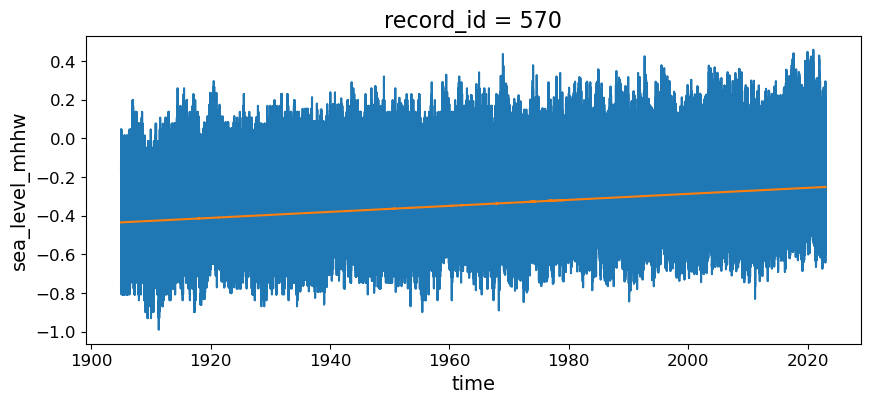

In [114]:
rsl_hourly['sea_level_mhhw'].sel(record_id=station_id).plot()
trend_line.sel(record_id=station_id).plot()

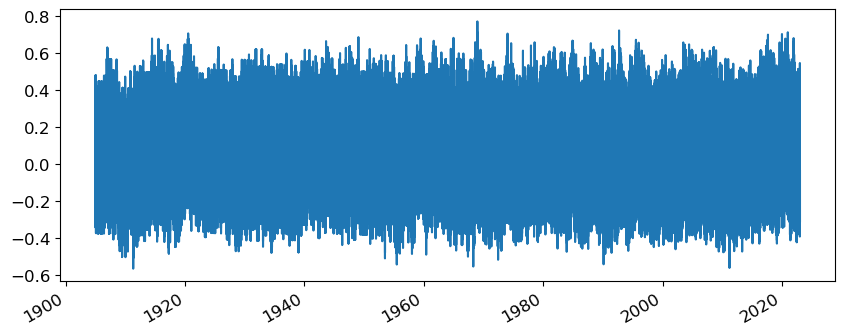

In [115]:
# turn sea_level_data into a series
sea_level_data_detrended = pd.Series(rsl_hourly['sea_level_mhhw'].sel(record_id=station_id)-trend_line.sel(record_id=station_id).values, index=pd.to_datetime(rsl_hourly['time'].values))
sea_level_data = pd.Series(rsl_hourly['sea_level_mhhw'].sel(record_id=station_id).values, index=pd.to_datetime(rsl_hourly['time'].values))

# plot sea_level_data_detrended
sea_level_data_detrended.plot()
# sea_level_data = sea_level_data - trend_rate*1000*time

# are there any nan values in the sea_level_data
sea_level_data_detrended.isnull().sum()

# fill in the nan values with zeros for now
sea_level_data_detrended = sea_level_data_detrended.fillna(0)
sea_level_data = sea_level_data.fillna(0)

Here, we are going to find extremes using the Block Maxima (BM) method. This will find all extreme values by selecting a block size (here we've chosen a year for the annual max, and 30 days for the monthly max). 

Text(0.5, 1.0, 'Annual Maxima')

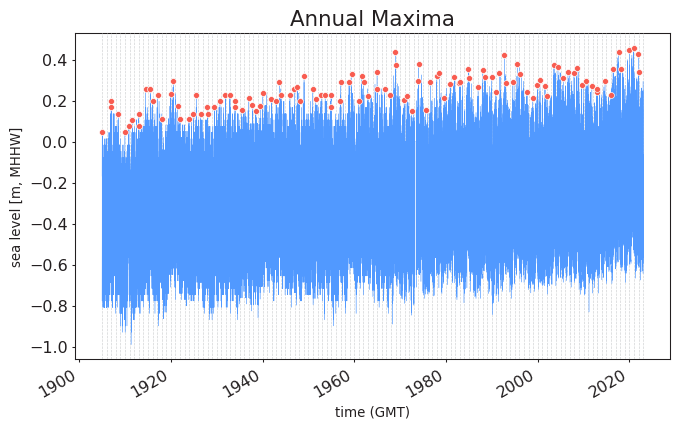

In [128]:
# label the data
sea_level_data.name = 'sea level [m, MHHW]'
sea_level_data.index.name = 'time (GMT)'
sea_level_data_detrended.name = 'sea level [m, detrended]'
sea_level_data_detrended.index.name = 'time (GMT)'

min_last_block_ratio = 0.9
# annual_max = get_extremes(sea_level_data_detrended, method='BM', block_size='365.2425D', extremes_type='high', min_last_block=min_last_block_ratio)
# monthly_max_detrended = get_extremes(sea_level_data_detrended, method='BM', block_size='30D', extremes_type='high', min_last_block=min_last_block_ratio)
# monthly_max = get_extremes(sea_level_data, method='BM', block_size='30D', extremes_type='high', min_last_block=min_last_block_ratio)


# return_periods = get_return_periods(ts = sea_level_data_detrended,extremes = monthly_max, extremes_method='BM', extremes_type='high', block_size='365.2425D', return_period_size='365.2425D', plotting_position='weibull')
# return_periods.sort_values('return period',ascending=False).head(10)

model = EVA(data = sea_level_data)
model.get_extremes(extremes_type='high', method='BM', block_size='365.24D',min_last_block=min_last_block_ratio)

fig, ax = model.plot_extremes()
ax.set_title('Annual Maxima')



In [138]:
# Get summary of the model
return_periods=[1, 2, 10, 100]

model.fit_model()

summary = model.get_summary(
    return_period=return_periods,
    alpha=0.95, n_samples=1000
)

#change name "return period" to "return period (yrs)"
summary = summary.rename(columns={'return period': 'return period (yrs)','return value':'water level (m, MHHW)','lower ci':'Lower CI (m, MHHW)','upper ci':'Upper CI (m, MHHW)'})

summary


,"water level (m, MHHW)","Lower CI (m, MHHW)","Upper CI (m, MHHW)"
return period,,,
1.0,-0.086818,-8.596209,-0.012151
2.0,0.253117,0.222009,0.321019
10.0,0.367456,0.347461,0.444119
100.0,0.446680,0.423452,0.475243


In [161]:
# we'll do this again for the detrended data
model_detrended = EVA(data = sea_level_data_detrended)
model_detrended.get_extremes(extremes_type='high', method='BM', block_size='365.24D',min_last_block=min_last_block_ratio)

model_detrended.fit_model()

summary_detrended = model_detrended.get_summary(
    return_period=return_periods,
    alpha=0.95, n_samples=1000
)

#change column names
summary_detrended = summary_detrended.rename(columns={'return value':'water level (m, MHHW)','lower ci':'Lower CI (m, MHHW)','upper ci':'Upper CI (m, MHHW)'})

Here trying to match the stuff on Phil's site: https://sealevel.nasa.gov/flooding-analysis-tool/observed-flooding?station-id=1612340&map=hide

I am using a slightly different model here - this is not the Markov Chain Monte Carlo estimation of the free parameters but MLE instead. I can switch it though? Let's see what happens. 

In [194]:
model_MCMC = EVA(data = sea_level_data)
model_MCMC.get_extremes(extremes_type='high', method='BM', block_size='365.24D',min_last_block=min_last_block_ratio)
model_MCMC = model_MCMC.fit_model(model='Emcee')

# jokes on you, this doesn't work.

Cool, so...there's something wrong with the data itself, I'd assume.

In [173]:
# mix this dataframe in with the SL_rankings table:
station_name = str(rsl_hourly['station_name'].sel(record_id=station_id).values)

tablename = 'SL_top_10_table_' + station_name + '.csv'
SL_rankings = pd.read_csv(output_dir / tablename, index_col=0)

# extract only 'Highest' and 'Highest Date' columns
SL_rankings = SL_rankings[['Highest','Highest Date']]

#rename 'Highest' to sea level (m, MHHW)
SL_rankings = SL_rankings.rename(columns={'Highest':'water level (m, MHHW)'})

# Ensure 'water level (m, MHHW)' column is numeric for both DataFrames
SL_rankings['water level (m, MHHW)'] = pd.to_numeric(SL_rankings['water level (m, MHHW)'], errors='coerce')
summary['water level (m, MHHW)'] = pd.to_numeric(summary['water level (m, MHHW)'], errors='coerce')

# Merge the SL_rankings DataFrame with the summary DataFrame on 'water level (m, MHHW)'
SL_rankings = pd.merge(SL_rankings, summary.reset_index(), on='water level (m, MHHW)', how='outer')

SL_rankings = SL_rankings.sort_values('water level (m, MHHW)',ascending=False)

SL_rankings['Date or Return Period'] = SL_rankings.apply(
    lambda row: row['Highest Date'] if pd.notnull(row['Highest Date']) else row['return period'], axis=1

)

SL_rankings = SL_rankings.drop(columns=['Highest Date','return period','Lower CI (m, MHHW)','Upper CI (m, MHHW)'])


# add a column for water level in feet
SL_rankings['water level (ft, MHHW)'] = SL_rankings['water level (m, MHHW)']*3.281
SL_rankings


,"water level (m, MHHW)",Date or Return Period,"water level (ft, MHHW)"
13,0.458000,2020-12-15 15:00,1.502698
12,0.447000,2019-12-25 14:00,1.466607
11,0.446680,100.0,1.465556
10,0.440000,2017-08-21 01:00,1.443640
9,0.428000,2021-12-05 15:00,1.404268
8,0.423000,2020-07-20 02:00,1.387863
7,0.415000,2020-11-15 14:00,1.361615
6,0.411000,2020-10-19 16:00,1.348491
5,0.410000,2017-06-24 02:00,1.345210
4,0.406000,2020-07-05 02:00,1.332086


Something funky is happening for the 1 year return period. Not only are the confidence intervals completely bonkers but the value is way too low as well. Like, it should probably be above MHHW? What is happening. The value for a 1-year flood on Phil's page is 0.51ft. 

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='sea level [m, MHHW]'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='sea level [m, MHHW]', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

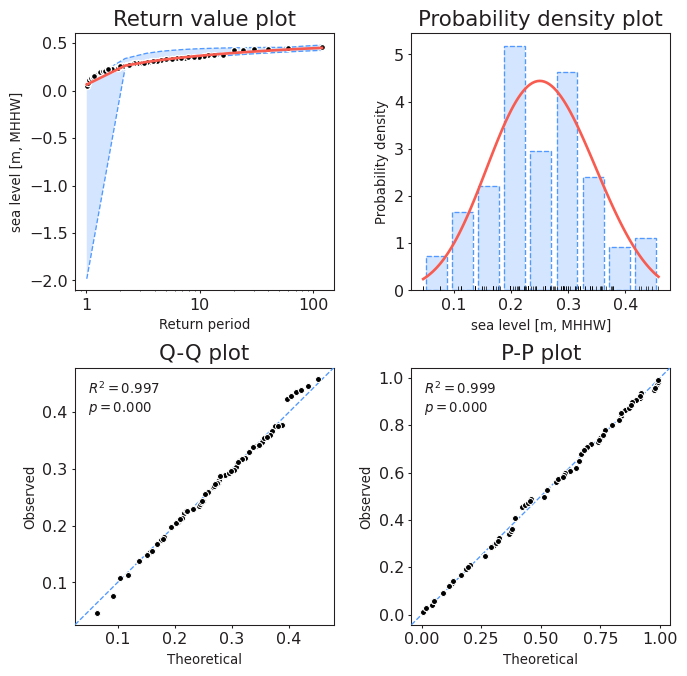

In [142]:
model.plot_diagnostic(alpha=0.95)

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='sea level [m, detrended]'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='sea level [m, detrended]', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

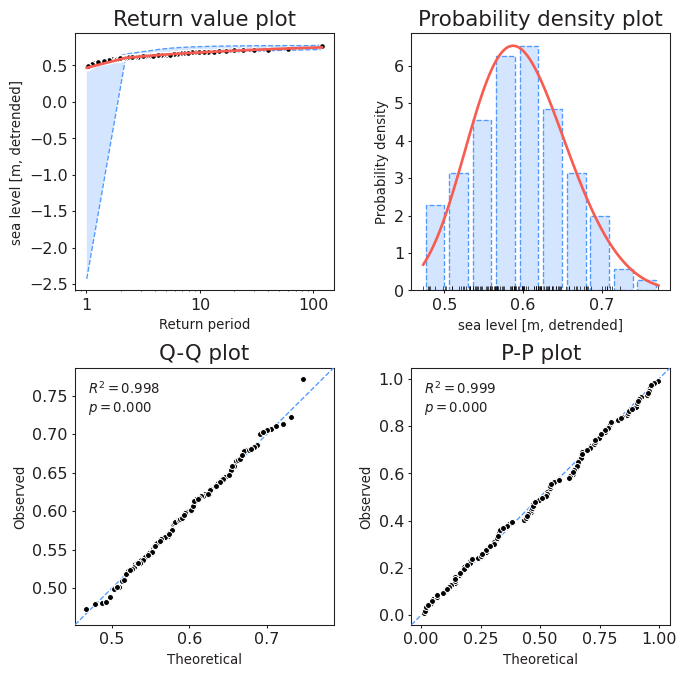

In [172]:
#let's do the same for the detrended model
model_detrended.plot_diagnostic(alpha=0.95)

```{caution}
Note!! Something is wrong with the 1 yr return. Can't quite figure out what's up.
```

For now, let's just replicate the NOAA style of plot.
We first need to extract the monthly maxima.

In [195]:
monthly_max = get_extremes(sea_level_data, method='BM', block_size='30D', extremes_type='high', min_last_block=min_last_block_ratio)

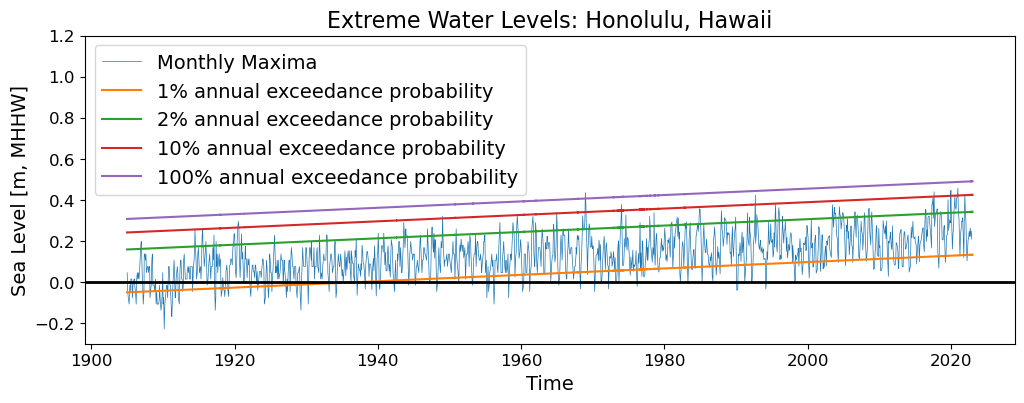

In [196]:
# plot the monthly maxima

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(monthly_max.index, monthly_max, label='Monthly Maxima',linewidth=0.5)
ax.set_xlabel('Time')
ax.set_ylabel('Sea Level [m, MHHW]')
ax.set_title(f'Extreme Water Levels: {station_name}')

ax.set_ylim(-0.3,1.2)

# Note here we use the detrended summary values to get the 1, 2, 10, and 100 year return levels
for i in [1,2,10,100]:
    prob_line = trend_line.sel(record_id=station_id).values + summary_detrended.loc[i, 'water level (m, MHHW)']
    ax.plot(rsl_hourly['time'].values, prob_line, label=f'{i}% annual exceedance probability')

# add bold black line at 0 for MHHW
ax.axhline(0, color='black', linewidth=2)
ax.legend()

## Following Merrifield, Firing & Marra:
This technique uses the Peaks Over Treshold (POT) technique to obtain extrema. This treshold is based on annual climatologies, obtained with the following steps:

1. Obtain hourly and daily mean tide gauge data from UHSLC
2. Deconstruct the time series into components with different timescales
3. Get high-pass filtered data:
    1. Remove linear trend
    2. Obtain low-frequency SL variability by smoothing daily data with a running Gaussian-shaped low-pass filter (half power period at ~5 months).
    3. Compute seasonal cycle by averaging daily mean WL over all years for each year day
    4. High-frequency SL is the residual of the daily means after removing #3,#4,#5
4. Tidal component is predicted with fits to hourly data
5. Reference all data to MHHW
6. Extreme events are the superposition of seasonal sea level, tidal and high frequency water level components.
    1. Tidal contribution is 95% exceedence threshold of daily highest water above MHHW on each day.
    2. HF variability is the 95% exceedance threshold of the HF filtered data on each year day.
7. Obtain TWL (H95) by stacking the seasonal sea level, 95% tide contribution, and 95% HF contribution

## Deconstruct the time series into components with different timescales.

### Get high-pass filtered data
#### Remove linear trend

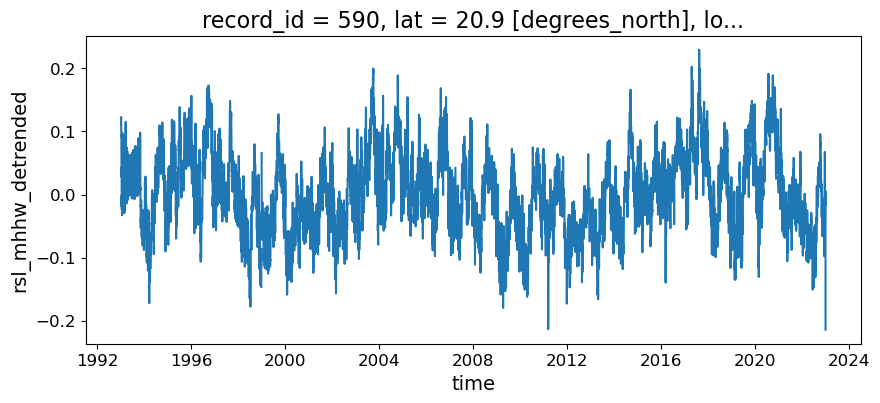

In [3]:
# remove the linear trend from rsl_daily

trend_mag, trend_line, trend_rate = process_trend_with_nan(rsl_daily['rsl_mhhw'])

rsl_daily['rsl_mhhw_detrended'] = rsl_daily['rsl_mhhw'] - trend_line

rsl_daily['rsl_mhhw_detrended'].sel(record_id = 590).plot()

#### Obtain low-frequency SL variability 
We'll do this by smoothing daily data with a running Gaussian-shaped low-pass filter (half power period at ~5 months).

In [4]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import detrend

# Define the filter parameters
half_power_period = 5 * 30  # Approximate number of days in 5 months
sigma = half_power_period / np.sqrt(8 * np.log(2))  # Convert half-power period to standard deviation

# Detrend each station's time series and handle NaNs
rsl_mhhw_detrended = np.empty_like(rsl_daily['rsl_mhhw'].values)

for i in range(rsl_daily['record_id'].size):
    data = rsl_daily['rsl_mhhw'][i, :].values
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    rsl_mhhw_detrended[i, :] = detrend(data)


# Apply the Gaussian filter to the detrended data
rsl_mhhw_detrended_filtered = gaussian_filter1d(rsl_mhhw_detrended, sigma=sigma, axis=1)

# Add the detrended and filtered data to the dataset
rsl_daily['rsl_mhhw_detrended_interp'] = (('record_id', 'time'), rsl_mhhw_detrended)
rsl_daily['rsl_mhhw_detrended_filtered'] = (('record_id', 'time'), rsl_mhhw_detrended_filtered)



#### Compute the seasonal cycle by averaging daily mean water levels over all years for each year day

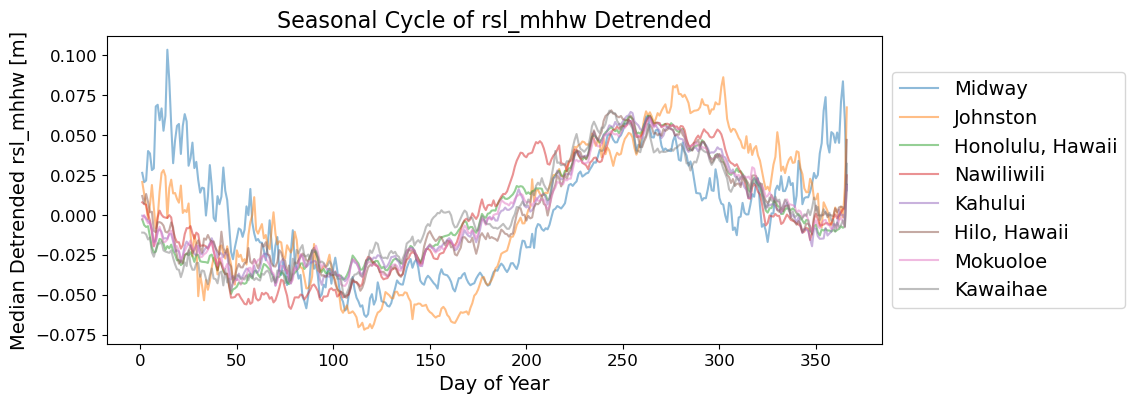

In [5]:
# Compute seasonal cycle by averaging daily rsl_mhhw over all years for each year day
seasonal_cycle = rsl_daily['rsl_mhhw_detrended'].groupby('time.dayofyear').mean(dim='time') 

# Plot the seasonal cycle, with 11 different lines, and add the station names to the legend
plt.figure()
for i in range(seasonal_cycle.shape[0]):
    plt.plot(seasonal_cycle['dayofyear'], seasonal_cycle[i, :], label=rsl_daily['station_name'].values[i], alpha=0.5)
plt.xlabel('Day of Year')
plt.ylabel('Median Detrended rsl_mhhw [m]')
plt.title('Seasonal Cycle of rsl_mhhw Detrended')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Obtain High Frequency data
It is the residual of the daily means after removing the linear trend, low-frequency variability, and seasonal cycle.

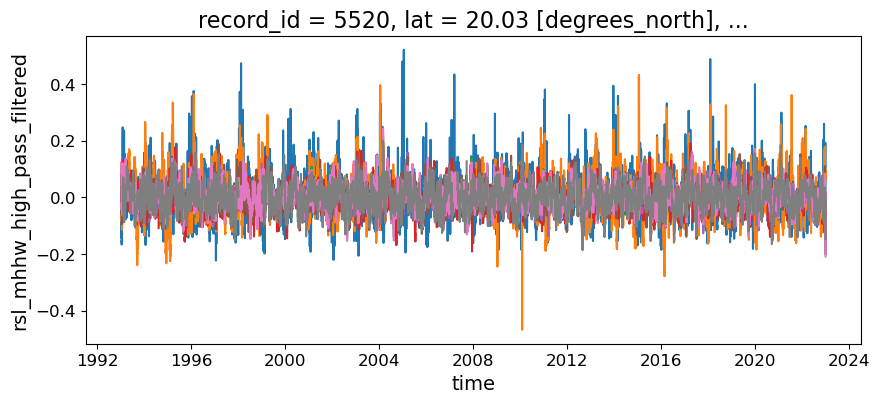

In [6]:
# Extend the seasonal cycle to the full time series length for each station
seasonal_cycle_full = seasonal_cycle.sel(dayofyear=rsl_daily['time'].dt.dayofyear)

# Compute the residual by removing the linear trend, filtered data, and seasonal cycle
residual = rsl_daily['rsl_mhhw_detrended'] - rsl_mhhw_detrended_filtered - seasonal_cycle_full

# Add the residual to the dataset
rsl_daily['rsl_mhhw_high_pass_filtered'] = (('record_id', 'time'), residual.values)

# Plot the residual for each station
plt.figure()
for i in range(rsl_daily['record_id'].size):
    rsl_daily['rsl_mhhw_high_pass_filtered'].sel(record_id=rsl_daily['record_id'][i]).plot(label=rsl_daily['station_name'].values[i])


### Tidal component is predicted with fits to hourly data

In [12]:
def split_continuous_segments(time, data, max_gap_hours=12):
    # Create a DataFrame from the time and data arrays
    df = pd.DataFrame({'time': time, 'data': data})
    
    # Calculate the time difference in hours
    df['time_diff'] = df['time'].diff().dt.total_seconds() / 3600
    
    # Identify the start of new segments
    df['segment'] = (df['time_diff'] > max_gap_hours).cumsum()
    
    # Group by the segment identifier and convert groups to list of tuples
    segments = [list(zip(group['time'], group['data'])) for _, group in df.groupby('segment')]
    
    return segments

In [8]:
# convert time in rsl_hourly to fractional year, starting at 0
time = rsl_hourly['time']
time = time - time[0]
time = time/np.timedelta64(1, 'D')
time = time/365.25

In [13]:
# check to make sure that data_dir/rsl_hawaii_tidal_predictions.nc exists, if not, run the following code to create it
if not (data_dir / 'rsl_hawaii_tidal_predictions.nc').exists():
    print('rsl_hawaii_tidal_predictions.nc not found in ../../data. Will proceed with tidal analysis and prediction.')


    # Prepare an empty array to store tidal predictions for all stations
    sea_level_shape = rsl_hourly['sea_level'].shape
    tidal_predictions = np.full(sea_level_shape, np.nan)  # Initialize with NaNs

    # Perform tidal analysis and prediction for each station
    for i, station_id in enumerate(rsl_hourly['record_id'].values):
        print('Processing ' + str(rsl_hourly['station_name'].sel(record_id=station_id).values))

        sea_level_data = rsl_hourly['sea_level'].sel(record_id=station_id).values
        #remove linear trend
        sea_level_data = sea_level_data - trend_rate.sel(record_id=station_id).values*1000*time
        # print the % nans in the data
        print('Percentage of NaNs in the data: ' + str(np.isnan(sea_level_data).sum() / len(sea_level_data) * 100) + '%')
        time_data = rsl_hourly['time'].values
        latitude = rsl_hourly['lat'].sel(record_id=station_id).values

        # Convert time_data to pandas datetime format for UTide
        time_series = pd.to_datetime(time_data)

        # Split data into continuous segments
        segments = split_continuous_segments(time_series, sea_level_data)
        print('Number of segments: ' + str(len(segments)))

        # Perform harmonic analysis on each segment
        for segment in segments:
            # print counter
            print('Processing segment ' + str(segments.index(segment) + 1) + ' of ' + str(len(segments)))
            segment_time, segment_data = zip(*segment)
            segment_time = np.array(segment_time)
            segment_data = np.array(segment_data)
    
            # Convert datetime to numeric format for interpolation
            segment_time_numeric = segment_time.astype('datetime64[s]').astype(np.float64)
    
            # Check for NaNs and interpolate to fill NaNs if needed
            if np.isnan(segment_data).any():
                mask = np.isnan(segment_data)
                interp_func = interp1d(segment_time_numeric[~mask], segment_data[~mask], kind='linear', fill_value="extrapolate")
                segment_data[mask] = interp_func(segment_time_numeric[mask])
    
            # Perform harmonic analysis
            coef = utide.solve(segment_time, segment_data, lat=latitude)
    
            # Predict the tide using the fitted model
            tide_pred = utide.reconstruct(segment_time, coef)
    
            # Store the tidal predictions in the array
            for t, pred in zip(segment_time, tide_pred.h):
                idx = np.where(time_series == t)[0][0]
                tidal_predictions[i, idx] = pred
    
    # Create the tidal predictions xarray Dataset with the same structure as rsl_hourly
    tidal_predictions_ds = xr.Dataset(
        data_vars={'tidal_prediction': (('record_id', 'time'), tidal_predictions)},
        coords={'time': rsl_hourly['time'].values, 'record_id': rsl_hourly['record_id'].values}
    )

    # save rsl_daily_combined to the data directory
    tidal_predictions_ds.to_netcdf(data_dir / 'rsl_hawaii_tidal_predictions.nc')
    print(f'Tidal predictions saved to: {data_dir / "rsl_hawaii_tidal_predictions.nc"}')

else:
    print('rsl_hawaii_tidal_predictions.nc found in ../../data. Proceed.')




rsl_hawaii_tidal_predictions.nc not found in ../../data. Will proceed with tidal analysis and prediction.
Processing Midway
Percentage of NaNs in the data: <xarray.DataArray 'time' ()> Size: 8B
array(38.86355581)%
Number of segments: 1
Processing segment 1 of 1
solve: matrix prep ... solution ... done.
prep/calcs ... done.


KeyboardInterrupt: 

Reference all data to MHHW

In [10]:
# open rsl_hawaii_tidal_predictions.nc
rsl_hawaii_tidal_predictions = xr.open_dataset(data_dir / 'rsl_hawaii_tidal_predictions.nc')
#

rsl_hawaii_tidal_predictions
#Adjust the tidal precictions to be in MHHW
# for station_id in rsl_hawaii_tidal_predictions.data_vars:
    # rsl_hawaii_tidal_predictions[station_id] = rsl_hawaii_tidal_predictions[station_id] + rsl_hourly['MHHW'].sel(record_id=int(station_id))

<xarray.Dataset> Size: 19MB
Dimensions:           (record_id: 8, time: 262945)
Coordinates:
  * time              (time) datetime64[ns] 2MB 1993-01-01 ... 2022-12-31
  * record_id         (record_id) int16 16B 500 520 570 580 590 600 610 5520
Data variables:
    tidal_prediction  (record_id, time) float64 17MB ...

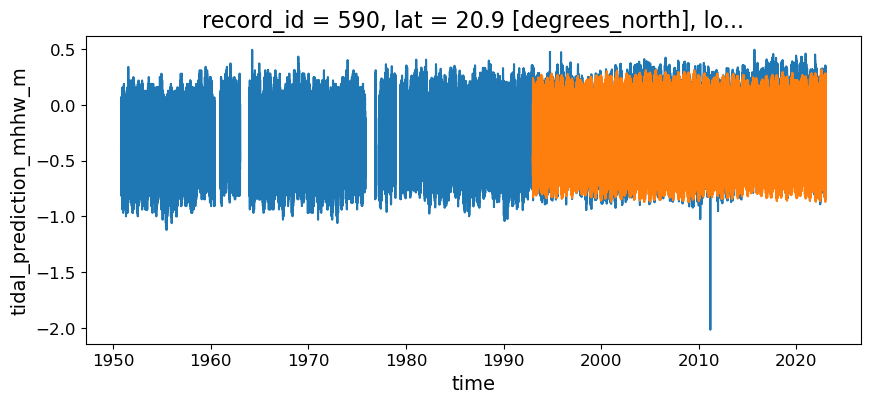

In [30]:
# reference it to MHHW
rsl_hawaii_tidal_predictions['tidal_prediction_mhhw_m'] = 0.001*(rsl_hawaii_tidal_predictions['tidal_prediction'] - rsl_hourly['MHHW'])

#plot the tidal predictions for Honolulu
rid = 4
rsl_hourly['sea_level_mhhw'] = 0.001*(rsl_hourly['sea_level'] - rsl_hourly['MHHW'])
rsl_hourly['sea_level_mhhw'].sel(record_id=rsl_daily.record_id[rid]).plot()
# rsl_daily['rsl_mhhw_detrended_interp'].sel(record_id=rsl_daily.record_id[rid]).plot()
rsl_hawaii_tidal_predictions['tidal_prediction_mhhw_m'].sel(record_id=rsl_daily.record_id[rid]).plot()


#### Find 95% exceedence threshold for tidal component


In [54]:
# "The tidal contribution is the 95% exceedance threshold of daily highest water above the MHHW on each year-day.""

# first we'll get "daily highest water"
rsl_daily_max_tidal = rsl_hawaii_tidal_predictions['tidal_prediction_mhhw_m']
# .groupby('time.day').max(dim='time')
#plot
# get daily max tidal prediction by resampling to daily and taking the max
rsl_daily_max_tidal = rsl_daily_max_tidal.resample(time='1D').max(dim='time')

#If we go by the exact wording in the Merrifield doc, it's the 95th percentile of the daily max tidal prediction
# and we need to do this on year day
# seasonal_cycle = rsl_daily['rsl_mhhw_detrended'].groupby('time.dayofyear').median(dim='time') #NOTE I AM USING MEDIAN!!!

# # get 95th percentile of rsl_daily_max_tidal
# rsl_daily_max_tidal_95 = rsl_daily_max_tidal.quantile(0.95, dim='time')

# rsl_daily_max_tidal_95

# rsl_daily_max_tidal_95 = rsl_daily_max_tidal.groupby('time.dayofyear').quantile(0.95, dim='time')
# rsl_daily_max_tidal_50 = rsl_daily_max_tidal.groupby('time.dayofyear').quantile(0.5, dim='time')
# rsl_daily_max_tidal_5 = rsl_daily_max_tidal.groupby('time.dayofyear').quantile(0.05, dim='time')


# rsl_daily_max_tidal_95



<xarray.DataArray 'tidal_prediction_mhhw_m' (record_id: 8, time: 10957)> Size: 701kB
array([[-0.05685111, -0.04610583, -0.02327568, ...,  0.01338249,
        -0.01718448, -0.15134759],
       [-0.17211191, -0.15837643, -0.12898361, ..., -0.13762976,
        -0.12696616, -0.30699197],
       [-0.18671624, -0.11667533, -0.0458284 , ..., -0.08482732,
        -0.17624745, -0.44216539],
       ...,
       [-0.25427672, -0.20491388, -0.11879857, ..., -0.07918098,
        -0.16589622, -0.57541788],
       [-0.19677359, -0.1863024 , -0.1010881 , ..., -0.06709136,
        -0.14138376, -0.53123128],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * record_id  (record_id) int16 16B 500 520 570 580 590 600 610 5520
  * time       (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31

HF variability is the 95% exceedance threshold of the HF filtered data on each year day.

In [42]:
# get the 95th percentile of the HF residual data
rsl_daily_residual_95 = rsl_daily['rsl_mhhw_high_pass_filtered'].groupby('time.dayofyear').quantile(0.95, dim='time')

rsl_daily_residual_95

<xarray.DataArray 'rsl_mhhw_high_pass_filtered' (record_id: 8, dayofyear: 366)> Size: 23kB
array([[ 0.11965809,  0.10497306,  0.14999267, ...,  0.23712092,
         0.17520128, -0.0040597 ],
       [ 0.17084396,  0.13907524,  0.12392569, ...,  0.08182192,
         0.09657972,  0.11127178],
       [ 0.04929298,  0.0536769 ,  0.05036697, ...,  0.06783159,
         0.0599701 ,  0.02223991],
       ...,
       [ 0.0858856 ,  0.08403567,  0.09186911, ...,  0.08221955,
         0.09405088,  0.10427528],
       [ 0.05621244,  0.07678304,  0.06169755, ...,  0.0621421 ,
         0.07790196,  0.03438324],
       [ 0.05305021,  0.05010486,  0.05973504, ...,  0.07680122,
         0.07654859,  0.04331168]])
Coordinates:
  * record_id     (record_id) int16 16B 500 520 570 580 590 600 610 5520
    lat           (record_id) float32 32B 28.22 16.75 21.31 ... 21.43 20.03
    lon           (record_id) float32 32B 182.6 190.5 202.1 ... 202.2 204.2
    station_name  (record_id) <U17 544B 'Midway' 'Johnston' ... 'Kawaihae'
    quantile      float64 8B 0.95
  * dayofyear     (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365 366

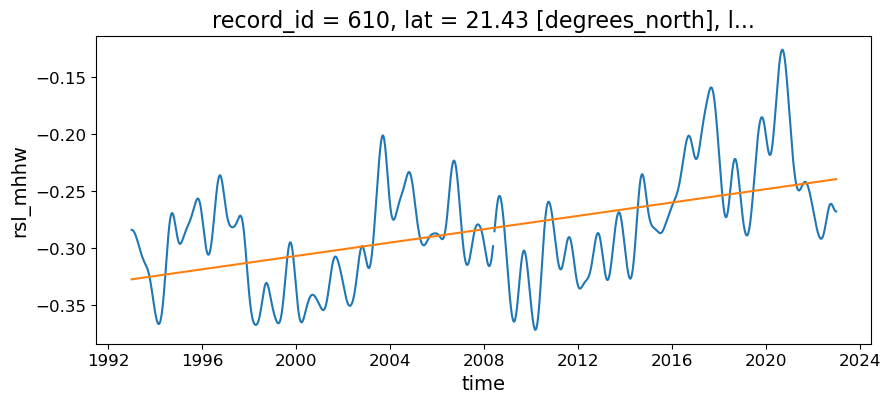

In [14]:
rsl_low_frequency = rsl_daily['rsl_mhhw_detrended_filtered'].sel(record_id=rsl_daily.record_id[rid]) + trend_line.sel(record_id=rsl_daily.record_id[rid])

# plot rsl_low_frequency, trend_line
rsl_low_frequency.plot()
trend_line.sel(record_id=rsl_daily.record_id[rid]).plot()

Obtain TWL (H95) by stacking the seasonal sea level, tide contribution, and HF contribution

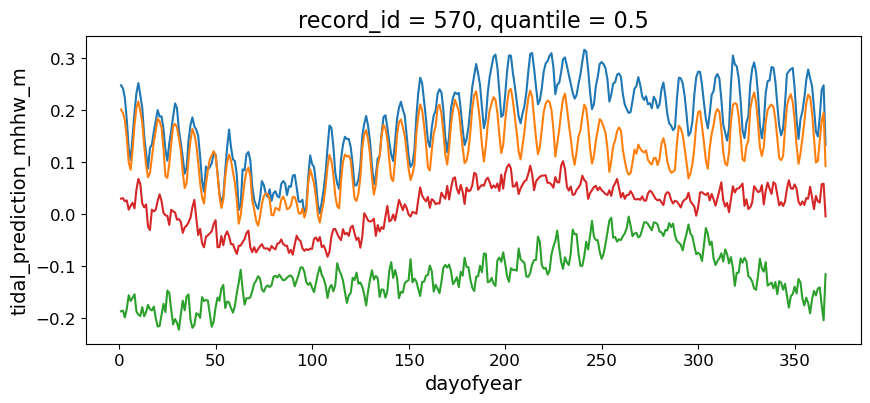

In [52]:
H95 = seasonal_cycle+ rsl_daily_max_tidal_95+ rsl_daily_residual_95
H95.sel(record_id=570).plot()
# seasonal_cycle.sel(record_id=570).plot()
rsl_daily_max_tidal_95.sel(record_id=570).plot()
rsl_daily_max_tidal_5.sel(record_id=570).plot()

rsl_daily_max_tidal_50.sel(record_id=570).plot()

# rsl_daily_residual_95.sel(record_id=570).plot()
